In [1]:
import matplotlib.pyplot as plt
from lmfit import Parameters
from lmfit import minimize, fit_report

In [2]:
import pyroll.core as pr
import pyroll.pillar_model
import pyroll.neutral_point_estimator
import pyroll.sparling_spreading
import pyroll.hensel_force_torque
import pyroll.freiberg_flow_stress
import pyroll.ring_model_thermal
from pyroll.freiberg_flow_stress import flow_stress

In [3]:
from in_profile import create_in_profile_for_finishing_train
from rolling_sequence import finishing_pass_design_1, finishing_pass_design_2, finishing_pass_design_3
from utilities import *

In [4]:
pyroll.pillar_model.Config.PILLAR_COUNT = 30
pyroll.neutral_point_estimator.Config.ESTIMATOR = "EQUAL"
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

In [5]:
@pr.CoolingPipe.DiskElement.heat_transfer_coefficient
def heat_transfer_coefficient_model_moreales(self: pr.CoolingPipe.DiskElement):
    mean_surface_temperature = (self.in_profile.surface_temperature + self.out_profile.surface_temperature) / 2
    profile_surface_temperature_celsius = mean_surface_temperature - 273.15
    return 13950 + 5.12 * 1e6 / profile_surface_temperature_celsius

In [6]:
in_profile = create_in_profile_for_finishing_train(950 + 273.15)
in_profile.ring_temperatures = in_profile.ring_temperatures

In [7]:
rolling_train_rpd1 = finishing_pass_design_1(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd2 = finishing_pass_design_2(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd3 = finishing_pass_design_3(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)

In [8]:
rolling_train_rpd1.solve(in_profile)
rolling_train_rpd2.solve(in_profile)
rolling_train_rpd3.solve(in_profile)

Solution iteration of TwoRollPass '17-H' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '21-H' exceeded the maximum iteration count of 100. Continuing anyway.


Profile(
    classifiers={'false_round', 'generic_elongation', 'round', 'symmetric'},
    core_temperature=np.float64(1397.7488582923372),
    cross_section=Polygon(
        area=5.82635230991946e-05,
        height=0.008700000000000006,
        perimeter=0.027129052642081364,
        width=0.008249205568719213,
        ),
    length=92.57470831110322,
    material=['BST500', 'steel'],
    ring_temperatures=array([1397.74885829, 1395.25908927, 1387.77992574, 1375.26436486,
           1357.5992688 , 1334.64557682, 1306.53190243, 1274.39348479,
           1241.40247337, 1213.15915741, 1195.80201163]),
    strain=np.float64(0.42927981011537364),
    surface_temperature=np.float64(1195.8020116297703),
    t=np.float64(1.8404522472310272),
    temperature=np.float64(1272.4336229716846),
    weight=2400,
    width=np.float64(0.008249205568719213),
    )

In [9]:
sequences = [
    {
        "label": "RPD1",
        "sequence": rolling_train_rpd1
    },
    {
         "label": "RPD2",
         "sequence": rolling_train_rpd2
    },
    {
        "label": "RPD3",
        "sequence": rolling_train_rpd3
    }
]

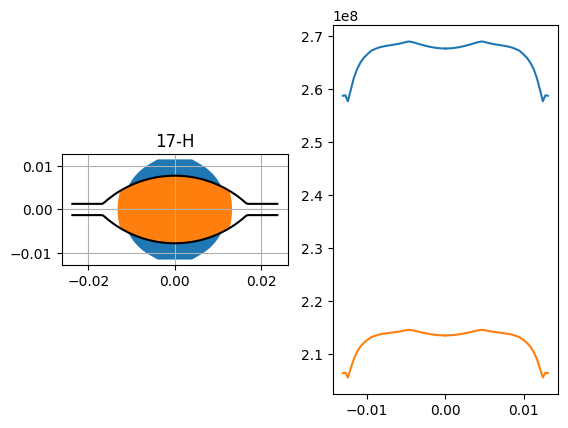

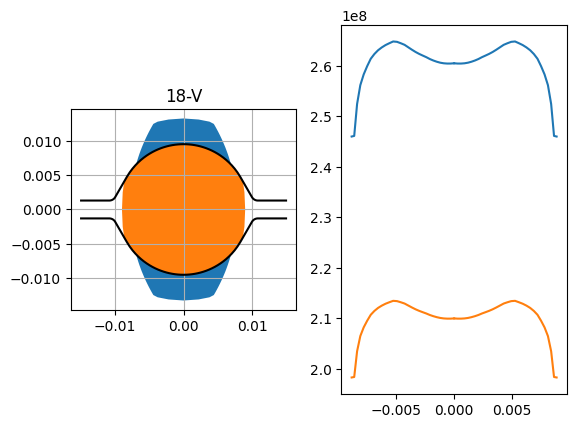

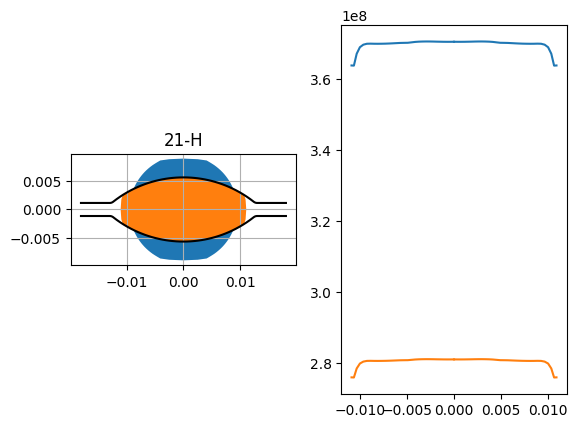

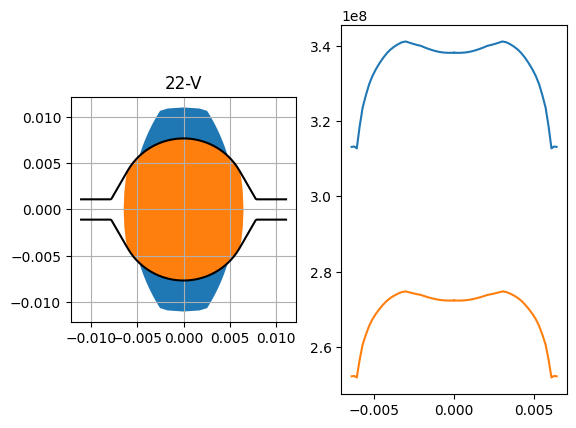

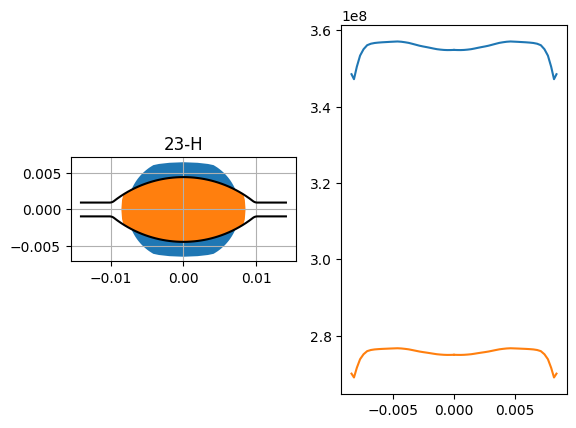

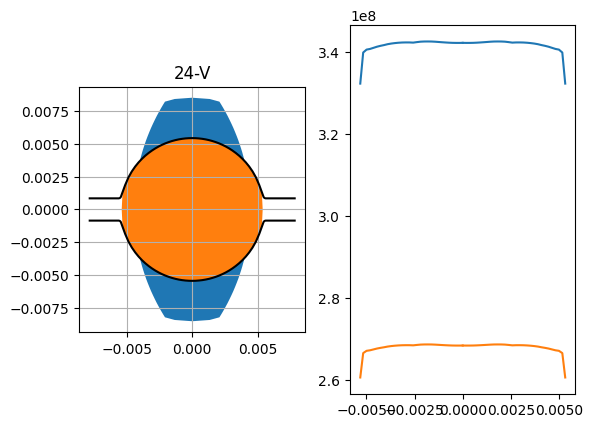

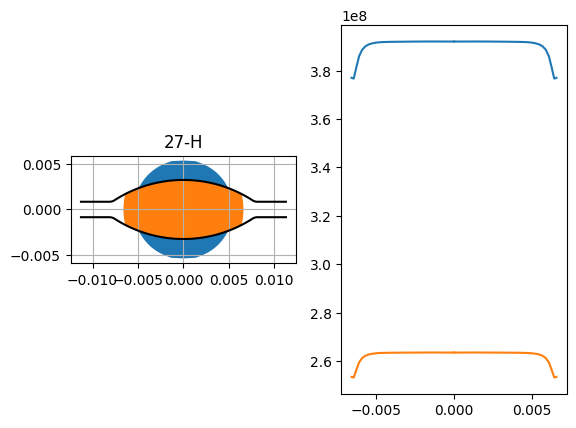

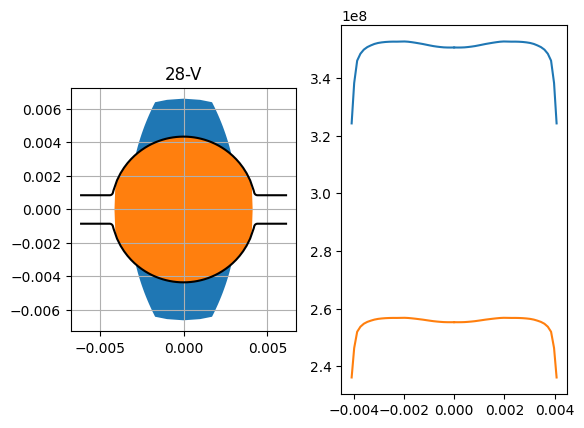

In [12]:
for roll_pass in sequences[2]["sequence"].roll_passes:
    fig, ax = plt.subplots(nrows=1, ncols=2)

    p_flow_stress = flow_stress(roll_pass.out_profile.freiberg_flow_stress_coefficients,
                                      roll_pass.total_pillar_strains,
                                      roll_pass.total_pillar_strain_rates,
                                      roll_pass.out_profile.temperature)

    p_deformation_resistance = pillar_deformation_resistance(roll_pass)
    ax[0].grid()
    ax[0].set_title(roll_pass.label)
    ax[0].fill(*roll_pass.in_profile.cross_section.boundary.xy)
    ax[0].fill(*roll_pass.out_profile.cross_section.boundary.xy)
    ax[0].set_aspect('equal')
    for cl in roll_pass.contour_lines.geoms:
        ax[0].plot(*cl.xy, color='black')

    ax[1].plot(roll_pass.out_profile.pillars, p_deformation_resistance, color='C0')
    ax[1].plot(-roll_pass.out_profile.pillars, p_deformation_resistance, color='C0')
    ax[1].plot(roll_pass.out_profile.pillars, p_flow_stress, color='C1')
    ax[1].plot(-roll_pass.out_profile.pillars, p_flow_stress, color='C1')

In [13]:
def solve_total_wear_depths_as_contour_line(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:

            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    print("RMS error: ", rms_error)
    return np.array(area_errors)


In [14]:
params_constant_cobyla = Parameters()
params_constant_cobyla.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

In [15]:
result_constant_cobyla = minimize(
    solve_total_wear_depths_as_contour_line,
    params_constant_cobyla,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

RMS error:  0.2864147951669552
RMS error:  682.5807649837855
RMS error:  634.3808640111728
RMS error:  161.83262701000174
RMS error:  51.88327258975681
RMS error:  7.8870647985748725
RMS error:  4.870837054836315
RMS error:  0.09061562985209136
RMS error:  0.5171266860063614
RMS error:  0.00845724040558637
RMS error:  0.00015540466140066494
RMS error:  0.004198927485702105
RMS error:  0.00018225250949943265
RMS error:  0.0006541295432020753
RMS error:  3.4098618969742185e-05
RMS error:  2.357974784221935e-06
RMS error:  8.127179273170321e-06
RMS error:  2.8621750195606736e-06
RMS error:  2.8621750195606736e-06
RMS error:  2.8621750195606736e-06
RMS error:  5.431764073554067e-05
RMS error:  8.127179273170321e-06


In [16]:
print(fit_report(result_constant_cobyla))

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 18
    # data points      = 61
    # variables        = 1
    chi-square         = 4.9971e-10
    reduced chi-square = 8.3286e-12
    Akaike info crit   = -1555.19930
    Bayesian info crit = -1553.08843
[[Variables]]
    wear_coefficient:  1.6322e-10 +/- 7.7089e-12 (4.72%) (init = 1e-05)


/tmp/ipykernel_236303/1403729133.py:13: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



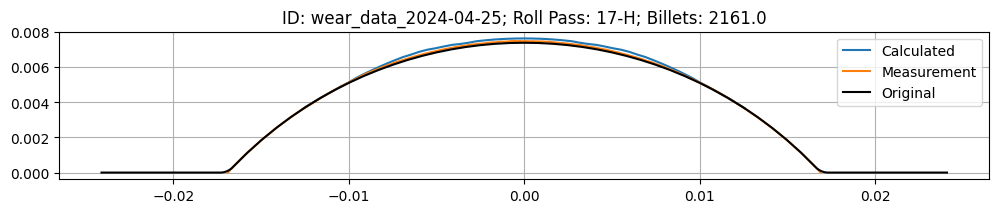

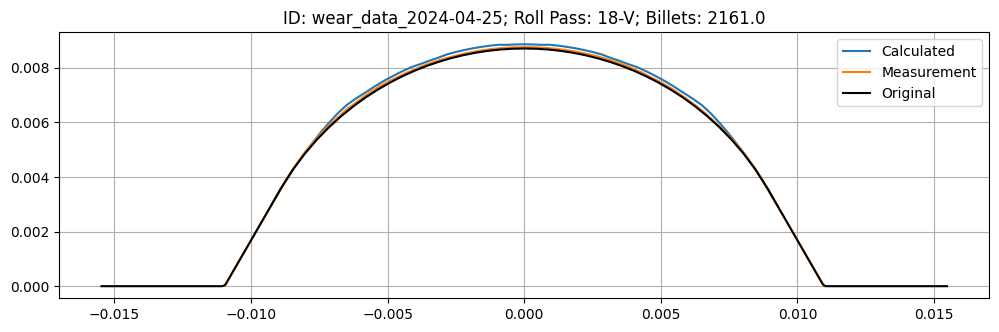

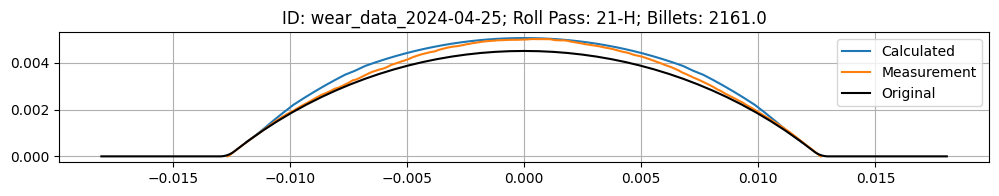

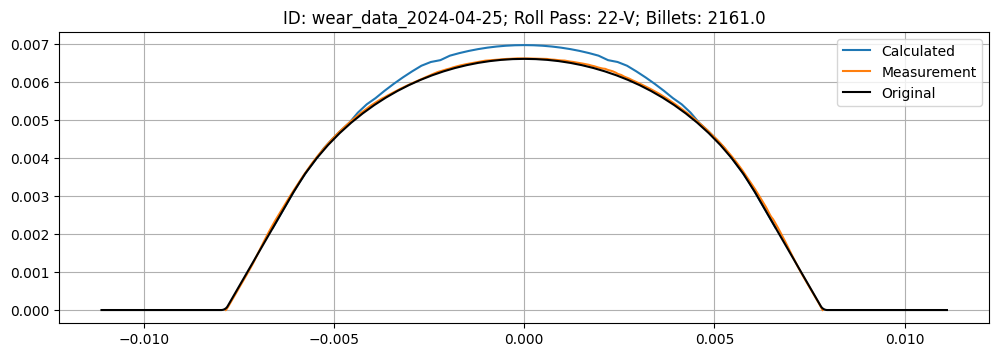

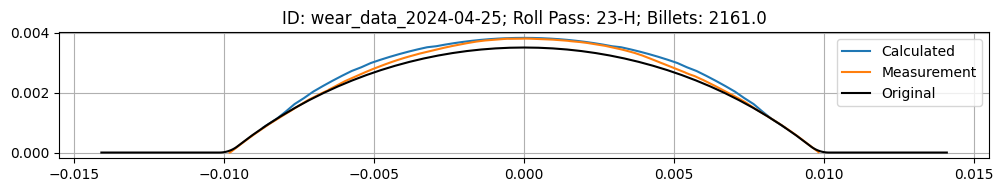

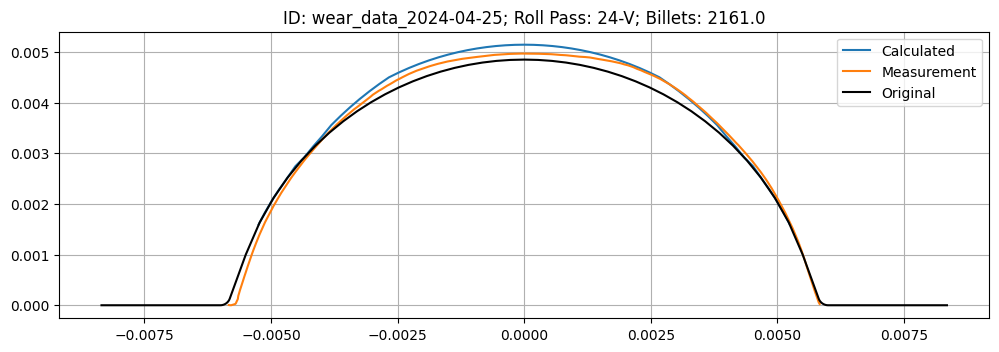

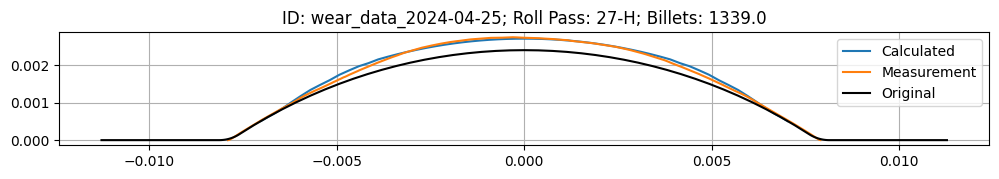

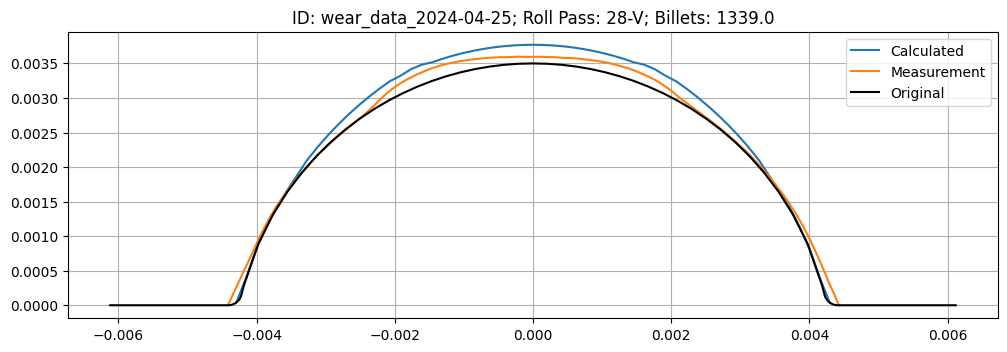

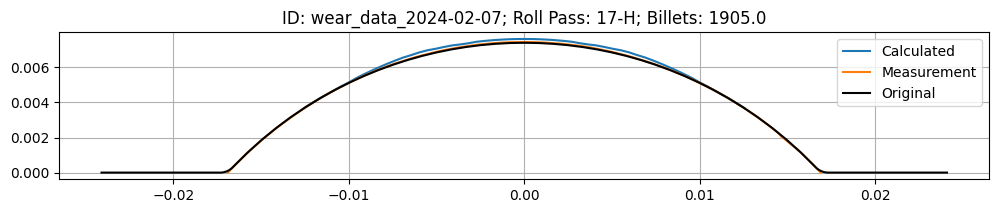

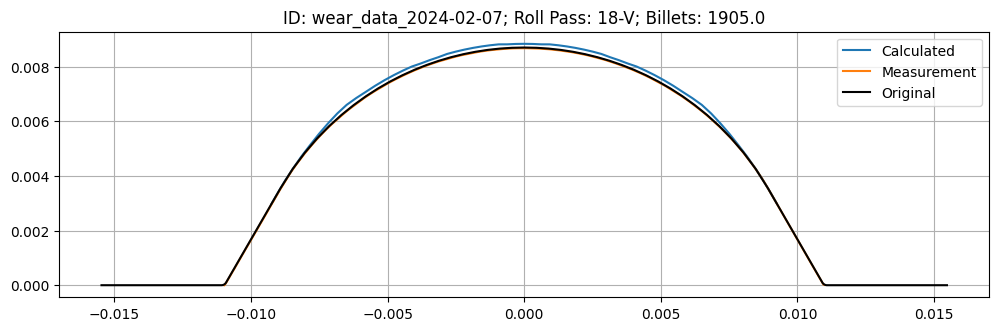

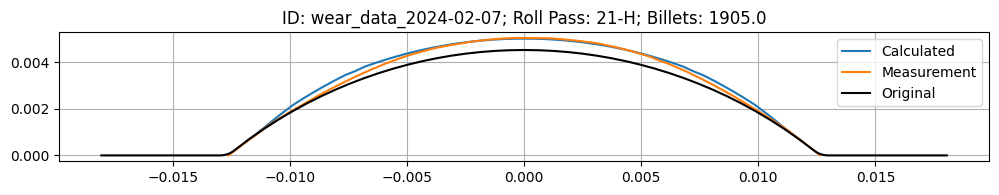

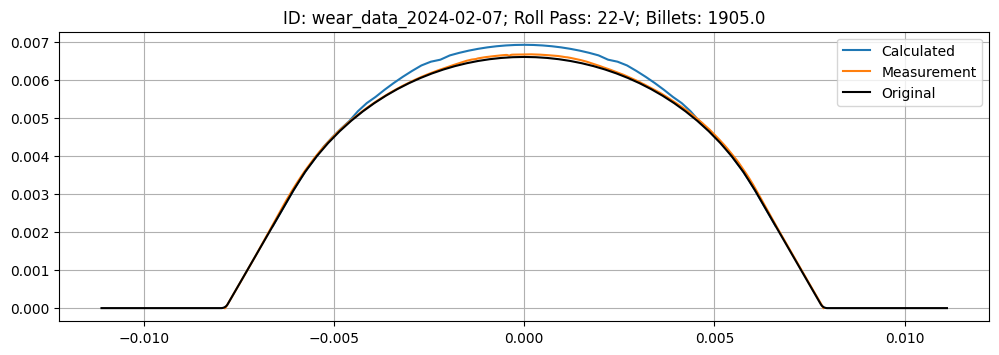

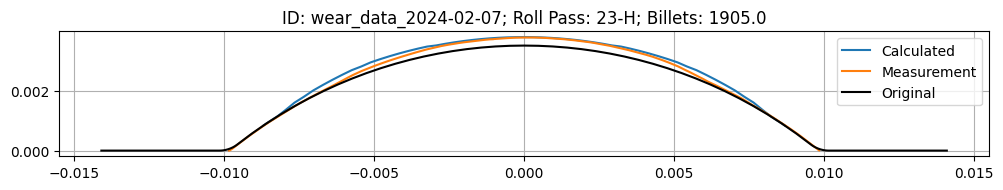

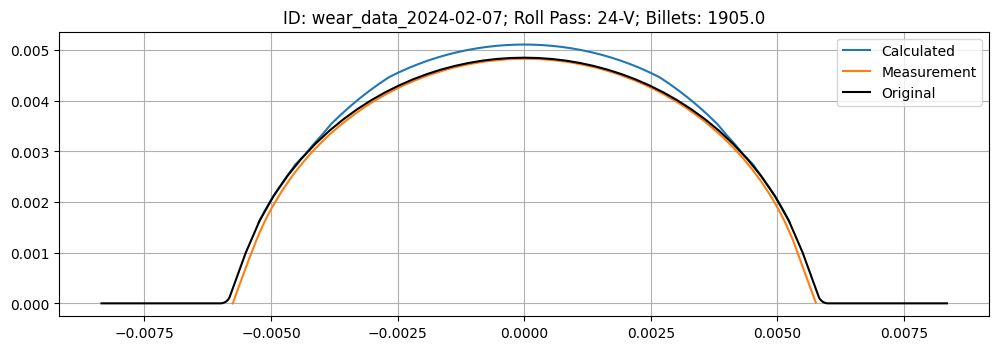

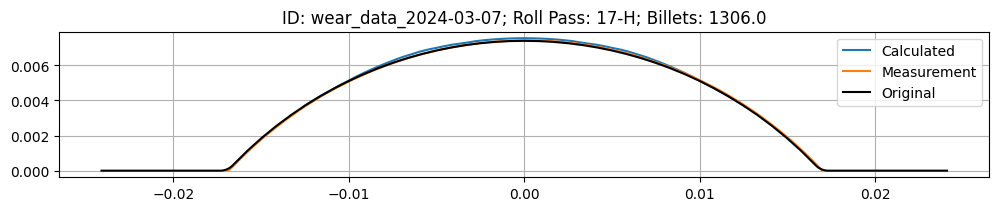

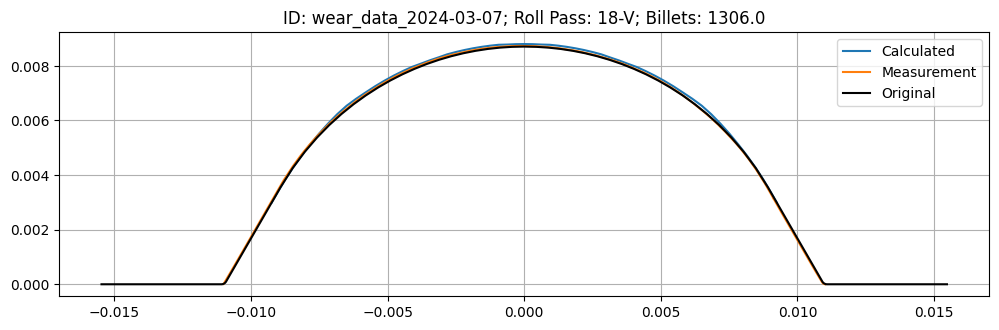

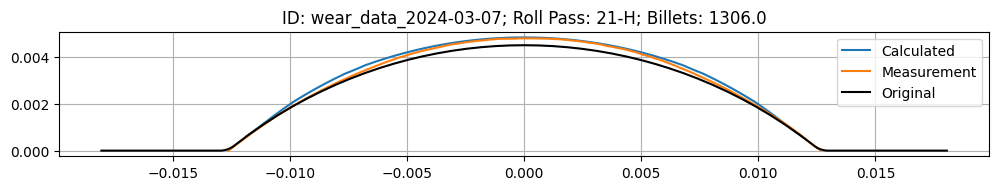

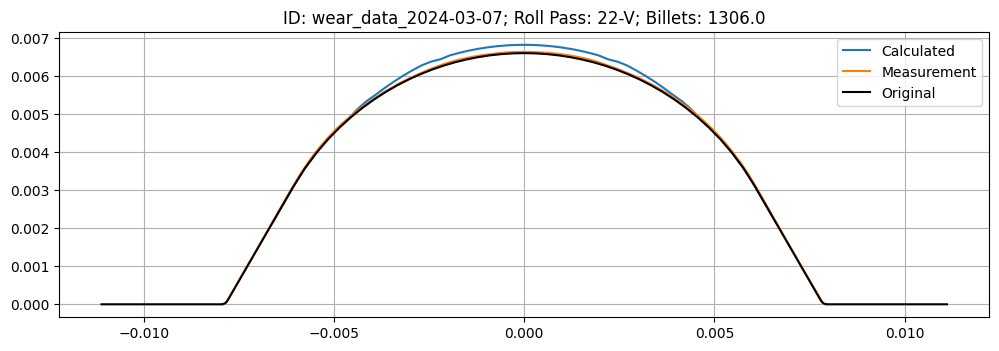

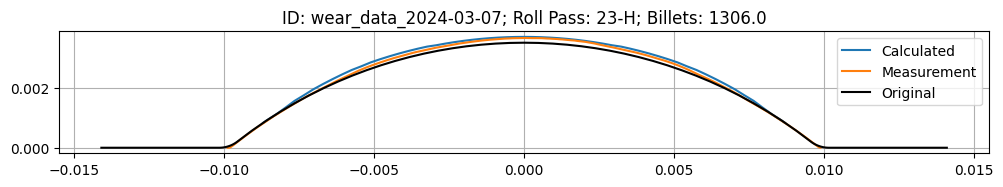

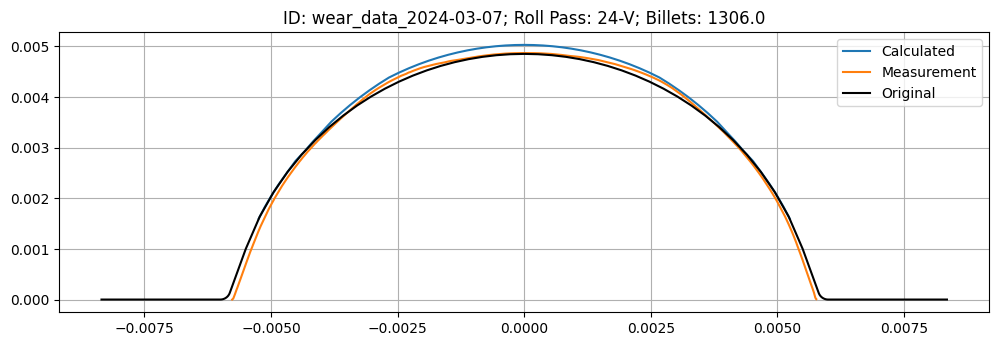

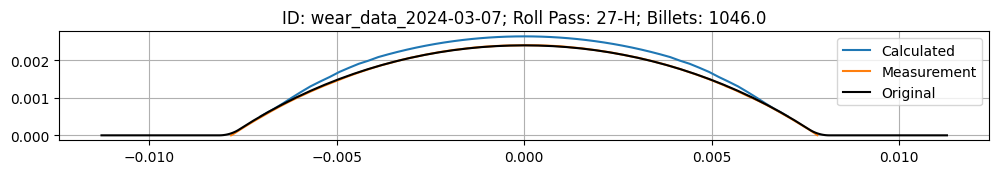

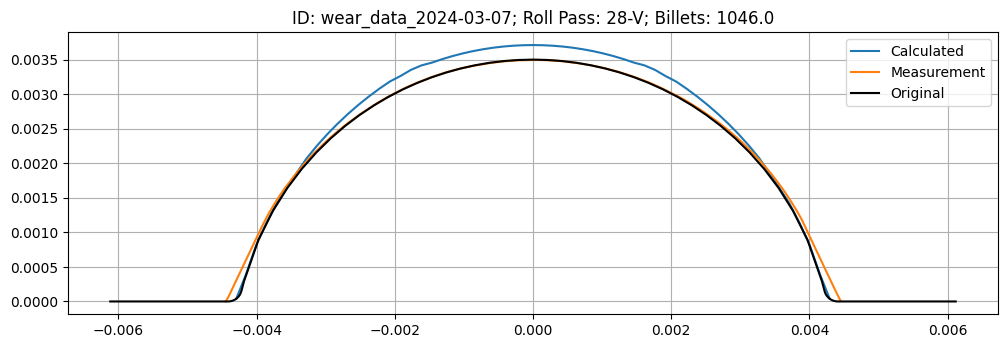

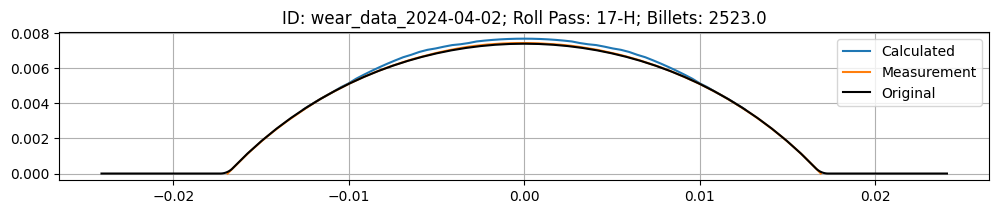

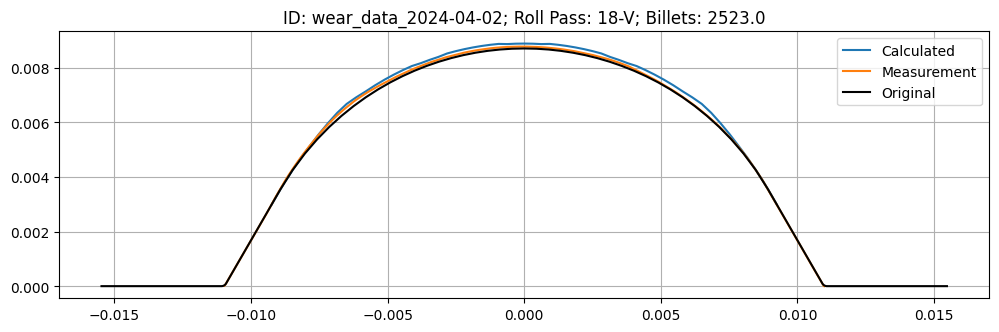

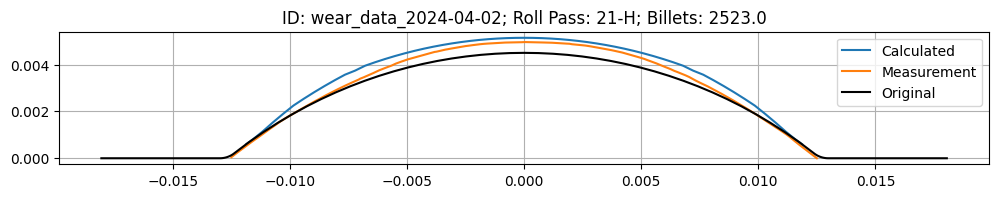

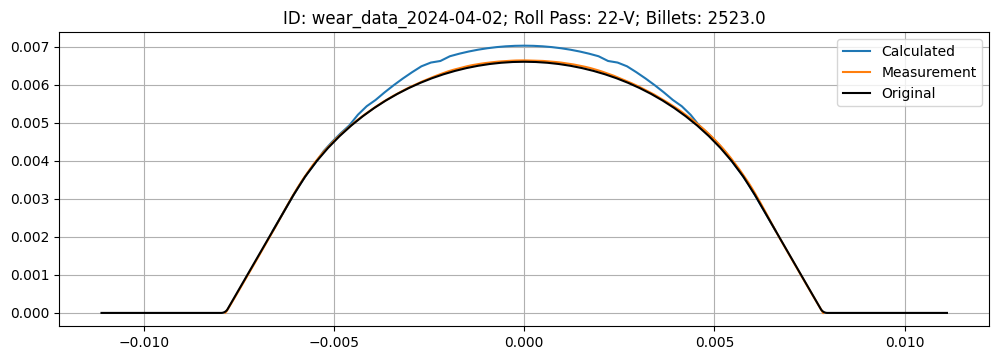

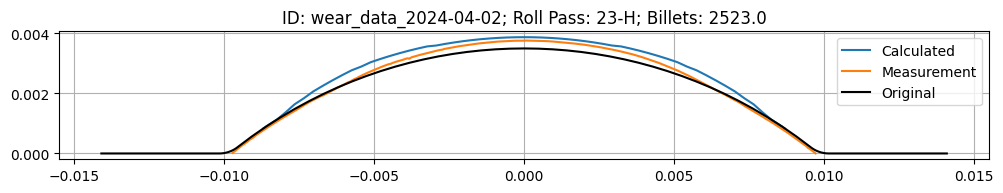

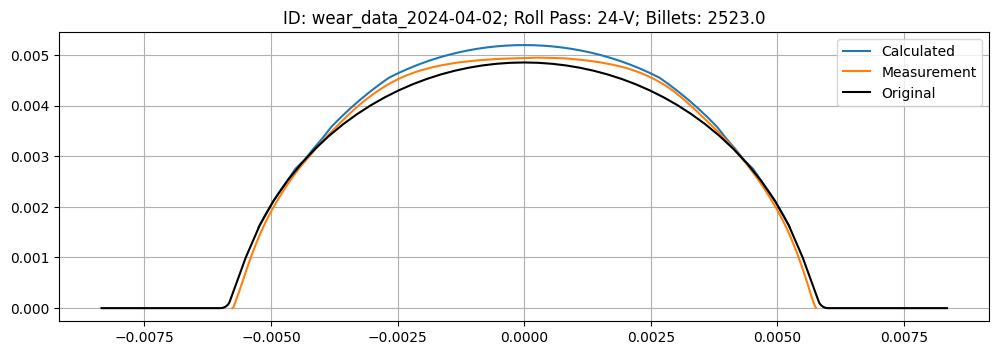

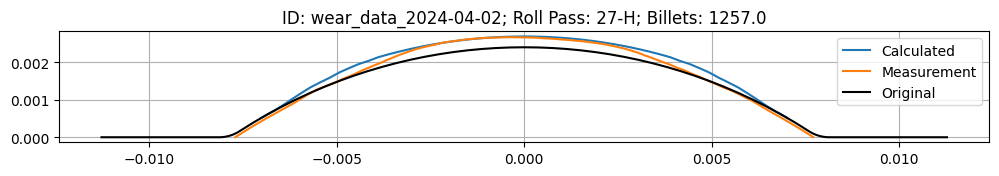

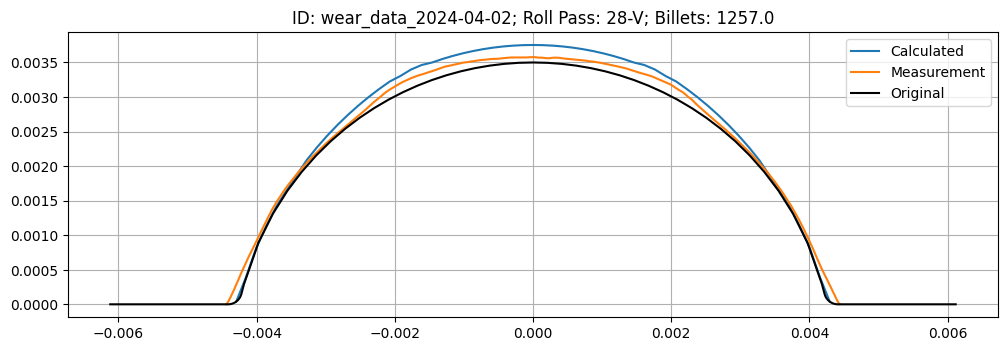

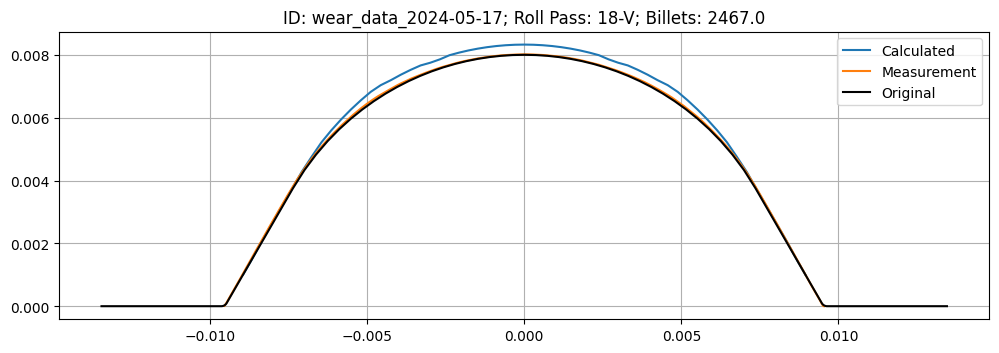

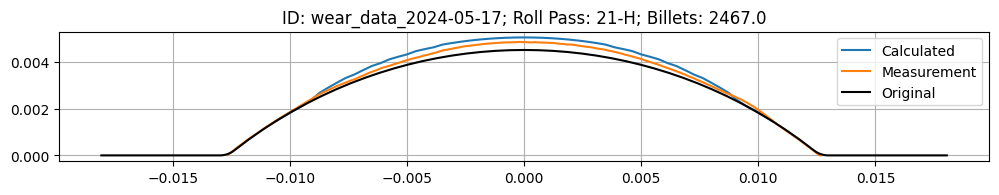

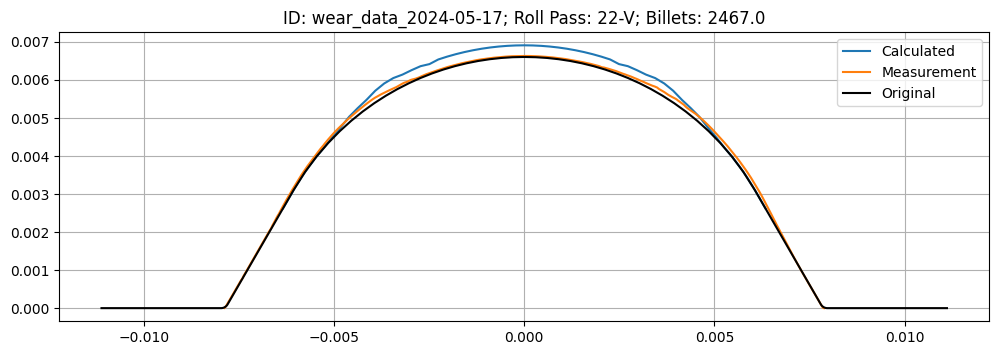

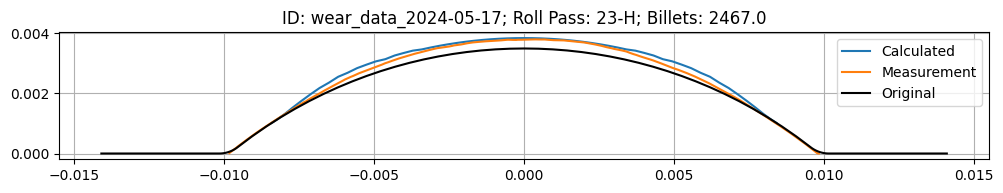

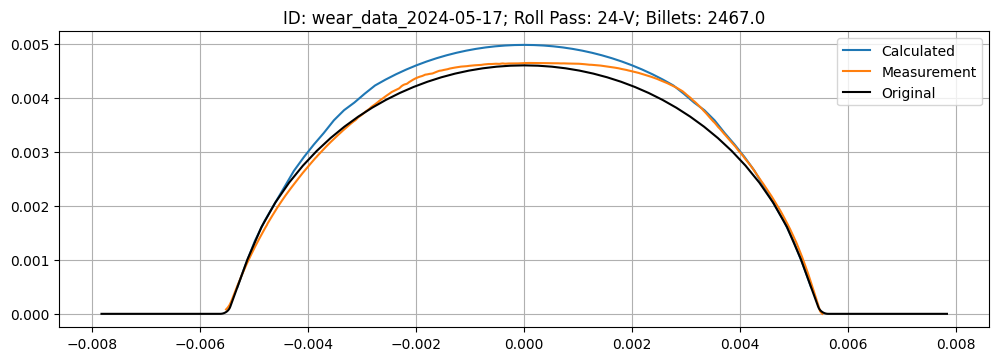

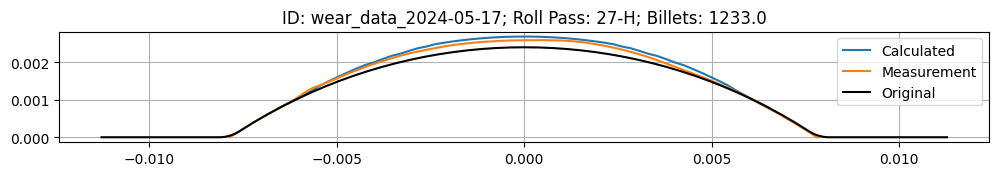

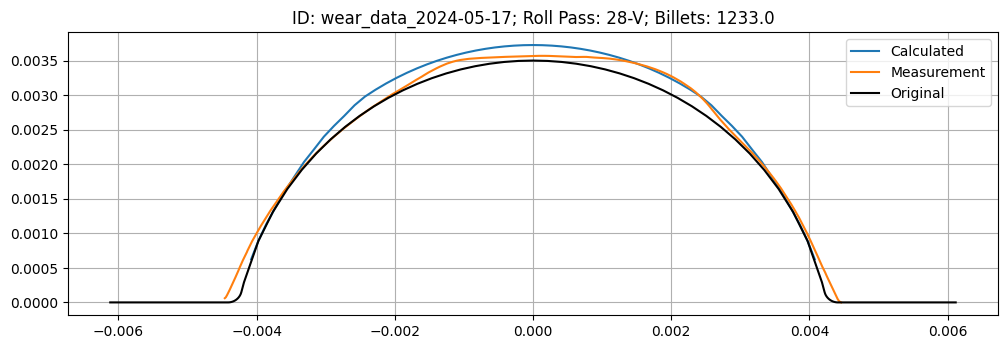

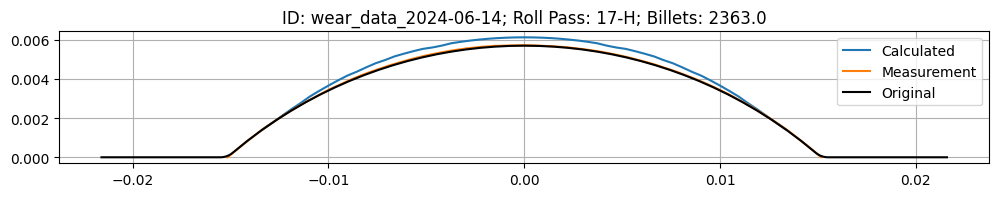

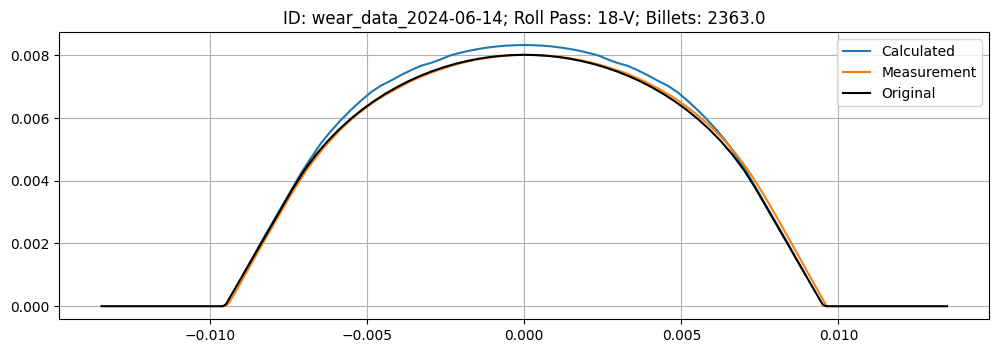

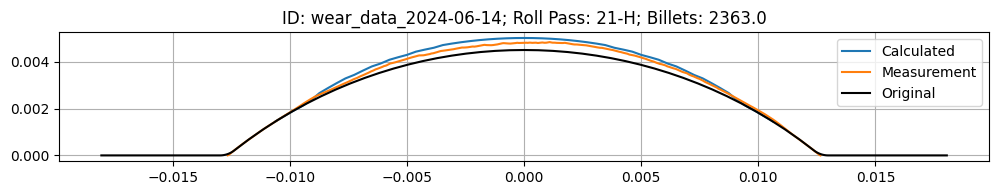

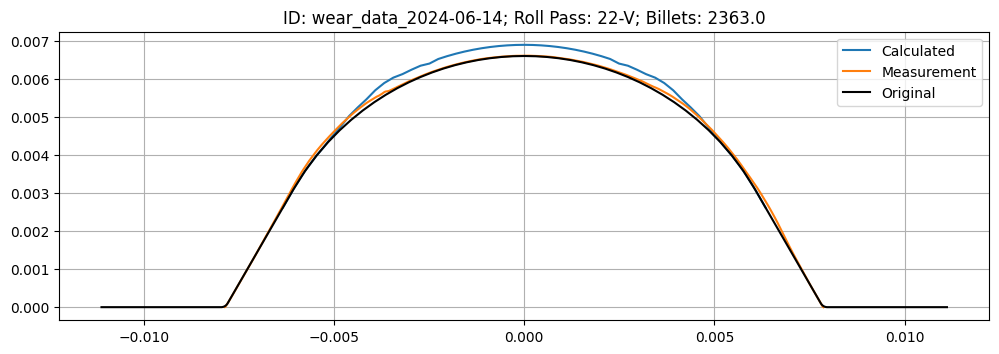

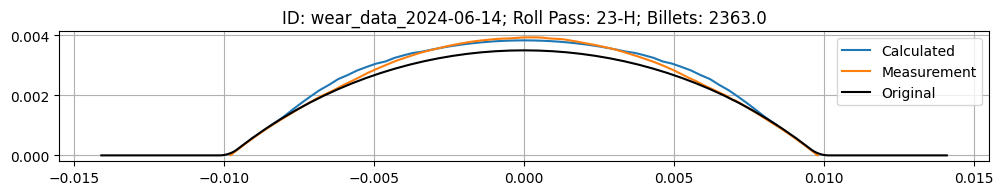

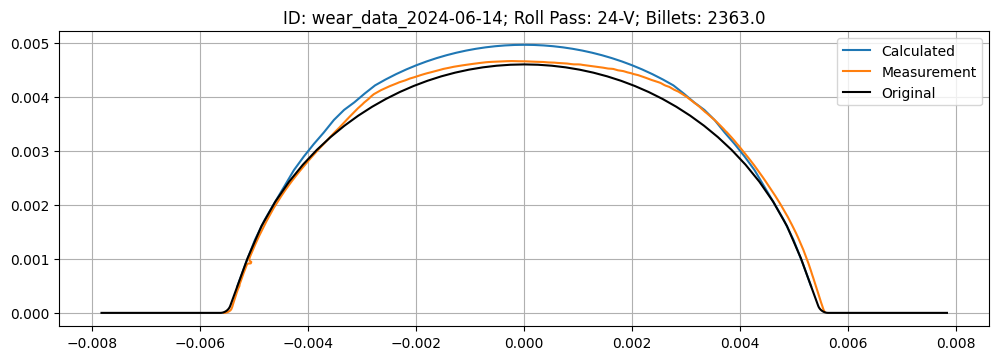

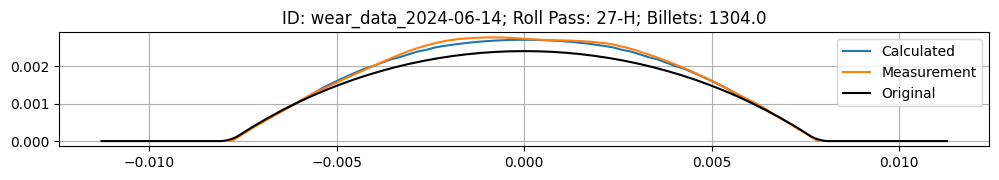

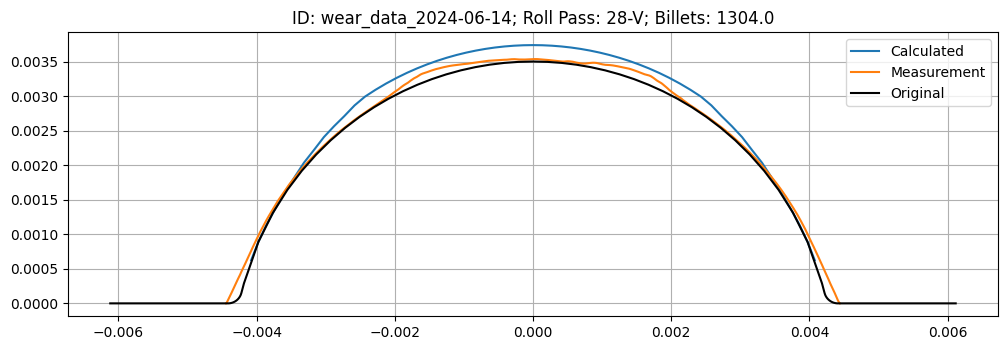

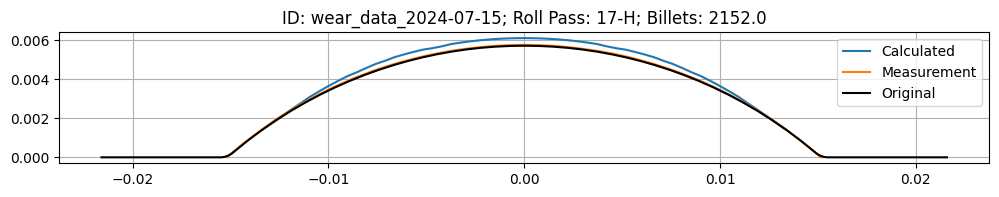

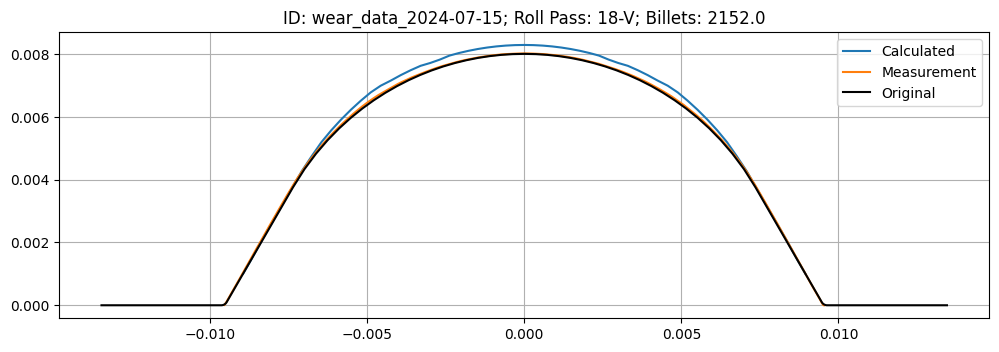

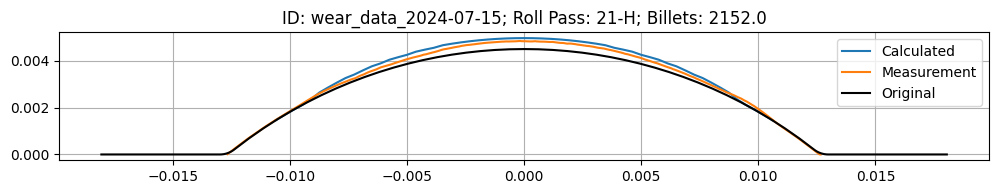

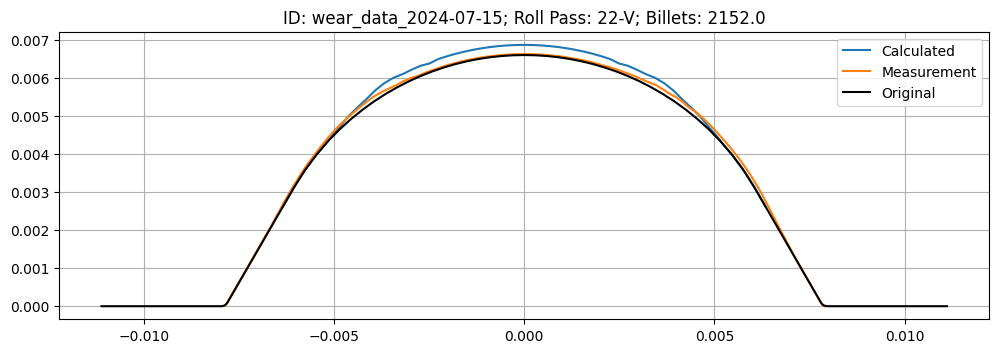

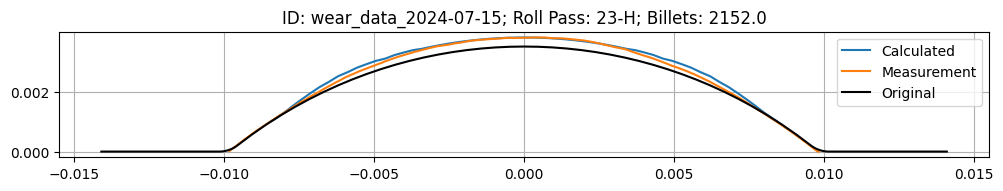

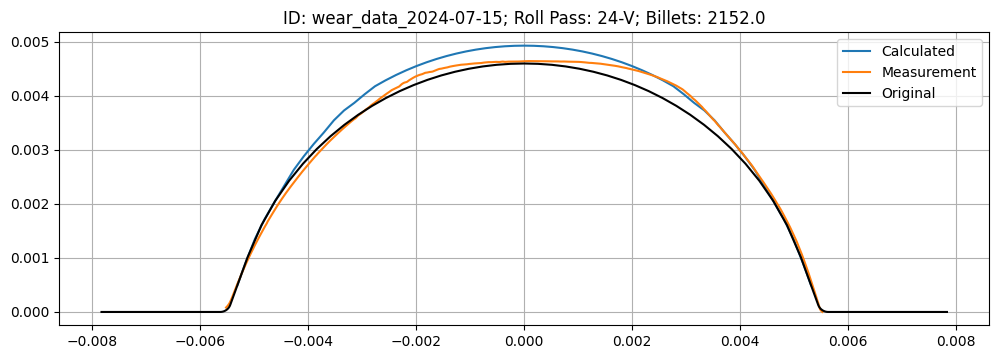

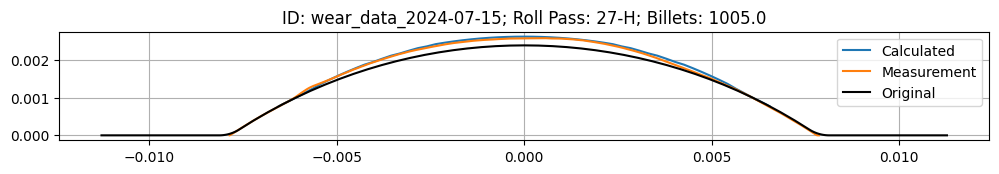

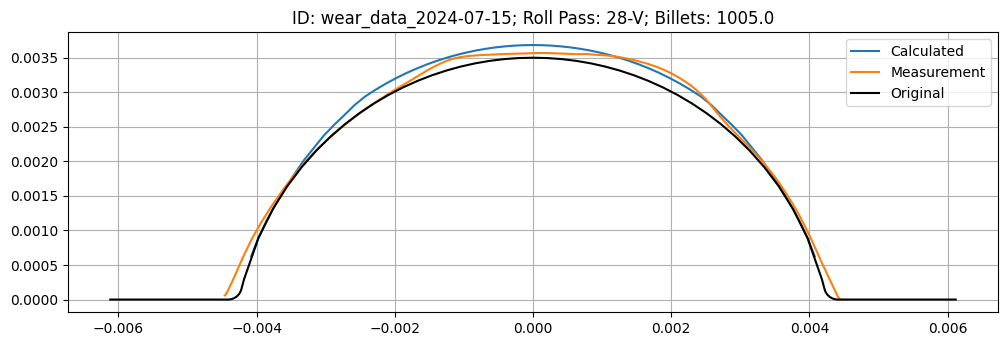

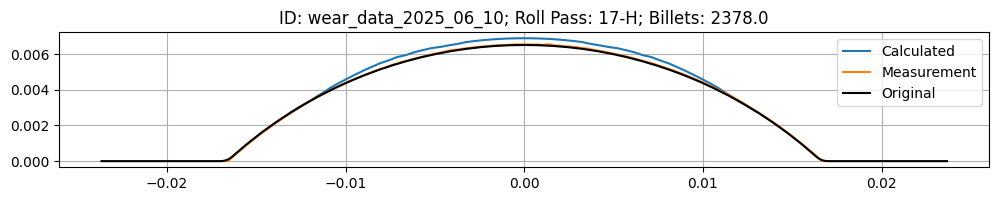

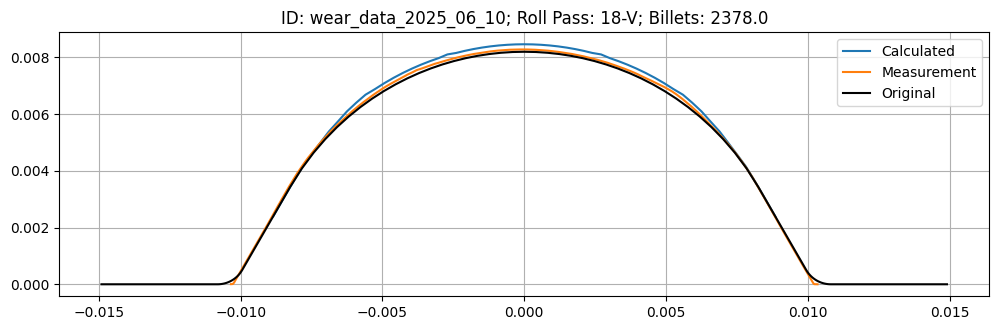

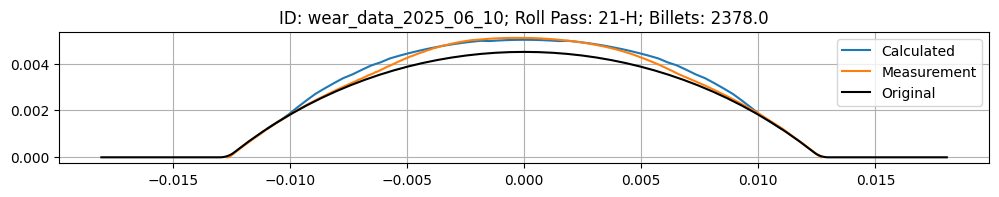

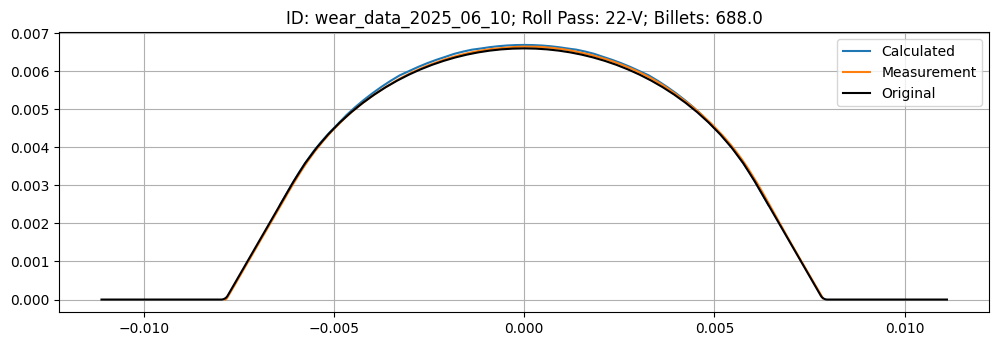

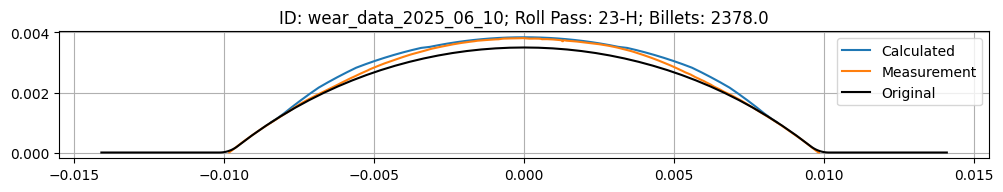

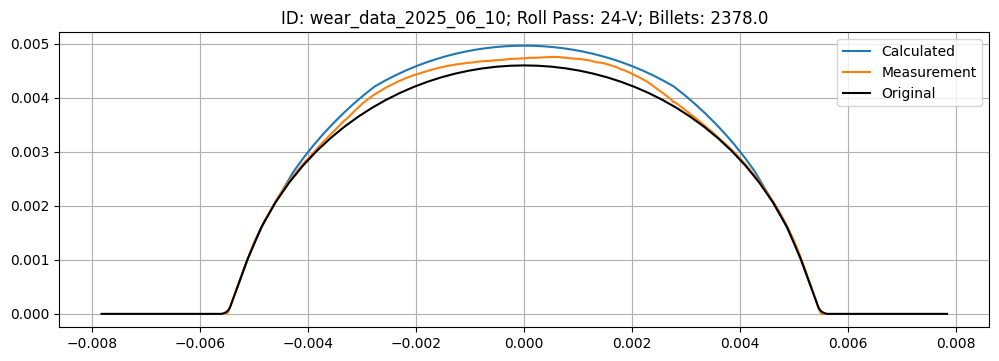

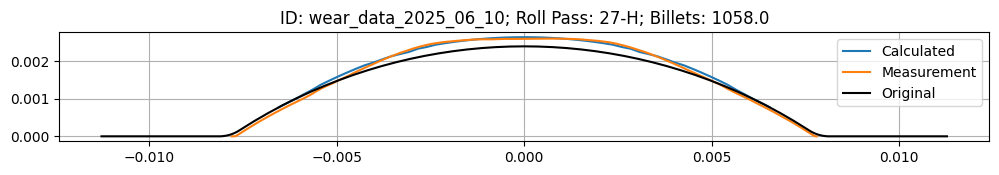

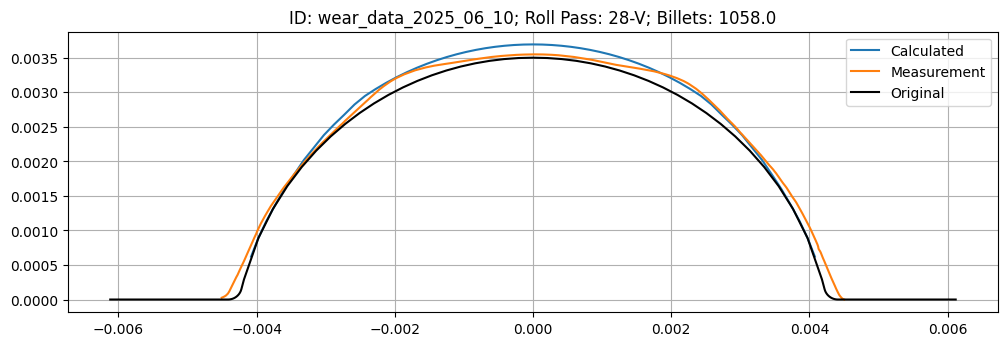

In [17]:
for entry in sequences:
    groove_label = entry["label"]
    sequence = entry["sequence"]
    roll_passes = sequence.roll_passes
    measurements = extract_wear_contours_from_measurement(groove_label)
    for measurement_id, labels, tonnages, measured_wear_contours in measurements:

        for roll_pass in roll_passes:
            for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                if roll_pass.label == label:
                    calculated_wear_contour = calculate_wear_contour(roll_pass, result_constant_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                    number_of_billets = np.round(tonnage * 1000 / 2400)
                    fig, ax = plt.subplots(figsize=(12, 8))
                    ax.grid()
                    title_string ="ID: " + measurement_id + "; Roll Pass: " + label + "; Billets: " + str(number_of_billets)
                    ax.set_title(title_string)
                    ax.set_aspect('equal')
                    ax.plot(*calculated_wear_contour.xy, label="Calculated")
                    ax.plot(*measured_wear_contour.xy, label="Measurement")
                    ax.plot(*roll_pass.roll.contour_line.xy, label="Original", color='black')
                    ax.legend()